# Plot Overview: RWTH + CALCE (BatteryML)

This notebook loads all processed cells from:
- `data/processed/RWTH/*.pkl`
- `data/processed/CALCE/*.pkl`

and plots, similar to `baseline.ipynb`:
- capacity degradation curves (normalized by nominal capacity)
- per-cycle traces (V/I/T vs time) for selected cycles
- coulombic efficiency vs cycle

Run Jupyter from the repo root, and make sure you already ran preprocessing:
```bash
batteryml download RWTH data/raw/RWTH
batteryml preprocess RWTH data/raw/RWTH data/processed/RWTH -q

batteryml download CALCE data/raw/CALCE
batteryml preprocess CALCE data/raw/CALCE data/processed/CALCE -q
```


In [1]:
from __future__ import annotations

from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np

from batteryml.data.battery_data import BatteryData
from batteryml.visualization.plot_helper import plot_capacity_degradation, plot_cycle_attribute

print('cwd:', os.getcwd())


cwd: c:\Users\FanWang\Documents\GitHub\BatteryML


In [2]:
RWTH_DIR = Path('data/processed/RWTH')
CALCE_DIR = Path('data/processed/CALCE')

def load_cells(dir_path: Path) -> list[BatteryData]:
    paths = sorted(dir_path.glob('*.pkl'))
    return [BatteryData.load(p) for p in paths]

rwth_cells = load_cells(RWTH_DIR) if RWTH_DIR.exists() else []
calce_cells = load_cells(CALCE_DIR) if CALCE_DIR.exists() else []

print('RWTH cells:', len(rwth_cells), 'dir exists:', RWTH_DIR.exists())
print('CALCE cells:', len(calce_cells), 'dir exists:', CALCE_DIR.exists())
if not rwth_cells and not calce_cells:
    raise FileNotFoundError('No processed .pkl found under data/processed/RWTH or data/processed/CALCE.')


RWTH cells: 48 dir exists: True
CALCE cells: 13 dir exists: True


## Capacity degradation (all cells)

`plot_capacity_degradation` plots capacity vs cycle index and optionally normalizes by `nominal_capacity_in_Ah`.


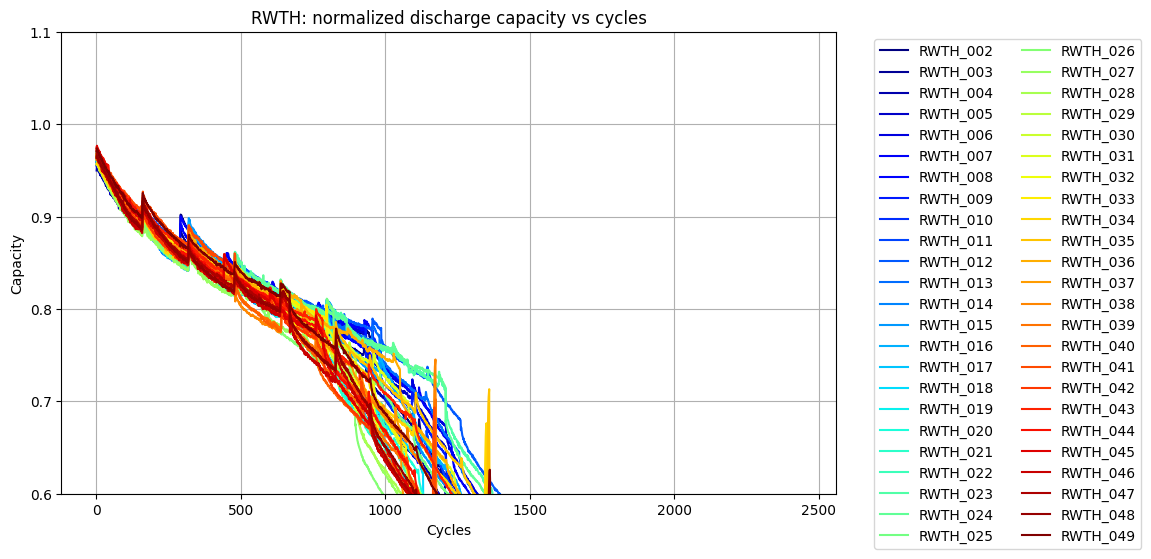

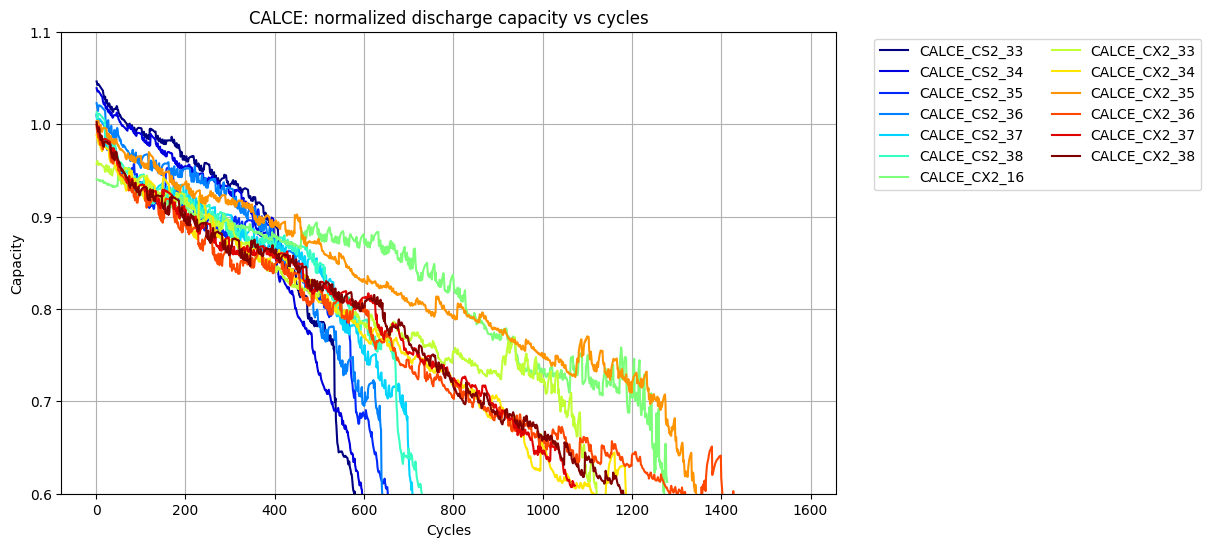

In [3]:
if rwth_cells:
    plot_capacity_degradation(
        rwth_cells,
        title='RWTH: normalized discharge capacity vs cycles',
        figsize=(10, 6),
        n_legend_cols=2,
        ylim=(0.6, 1.1),
    )

if calce_cells:
    plot_capacity_degradation(
        calce_cells,
        title='CALCE: normalized discharge capacity vs cycles',
        figsize=(10, 6),
        n_legend_cols=2,
        ylim=(0.6, 1.1),
    )


## Quick dataset summary

We compute per-cell: number of cycles, Q0, Qend, and SOH_end = Qend/Q0.


In [4]:
import pandas as pd

def summarize_cells(cells: list[BatteryData], tag: str) -> pd.DataFrame:
    rows = []
    for c in cells:
        if not c.cycle_data:
            continue
        q0 = float(np.max(c.cycle_data[0].discharge_capacity_in_Ah))
        qend = float(np.max(c.cycle_data[-1].discharge_capacity_in_Ah))
        rows.append({
            'dataset': tag,
            'cell_id': c.cell_id,
            'n_cycles': len(c.cycle_data),
            'q0_ah': q0,
            'qend_ah': qend,
            'soh_end': (qend / q0) if q0 else np.nan,
        })
    return pd.DataFrame(rows)

summary = pd.concat([
    summarize_cells(rwth_cells, 'RWTH'),
    summarize_cells(calce_cells, 'CALCE'),
], ignore_index=True)
summary.sort_values(['dataset', 'n_cycles'], ascending=[True, False]).head(10)


,dataset,cell_id,n_cycles,q0_ah,qend_ah,soh_end
60,CALCE,CALCE_CX2_38,1579,1.352997,0.327484,0.242044
58,CALCE,CALCE_CX2_36,1568,1.346995,0.541427,0.401952
57,CALCE,CALCE_CX2_35,1454,1.354551,0.555564,0.410146
56,CALCE,CALCE_CX2_34,1363,1.333922,0.559058,0.419108
54,CALCE,CALCE_CX2_16,1279,1.269461,0.827096,0.651533
55,CALCE,CALCE_CX2_33,1271,1.292034,0.559989,0.433417
59,CALCE,CALCE_CX2_37,1072,1.349392,0.821946,0.609123
52,CALCE,CALCE_CS2_37,905,1.109596,0.191208,0.172322
53,CALCE,CALCE_CS2_38,903,1.114125,0.295222,0.264981
51,CALCE,CALCE_CS2_36,832,1.124947,0.172276,0.153141


## Plot per-cycle traces for a selected cell

We select cycles by *cycle_number* (e.g. 1/100/200/600) and map them to list indices.


RWTH example RWTH_002 selected indices: [0, 99, 198, 597] cycle_numbers: [1, 100, 200, 600]


TypeError: 'NoneType' object is not subscriptable

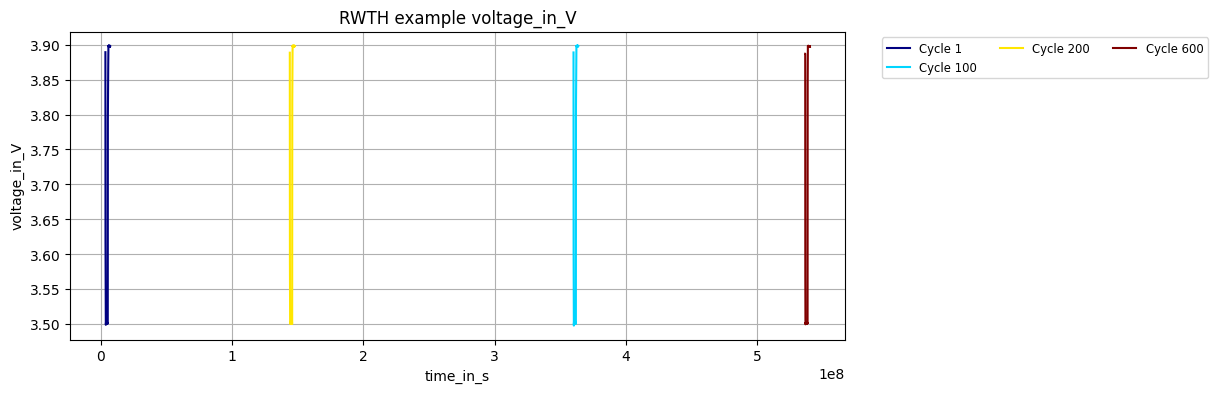

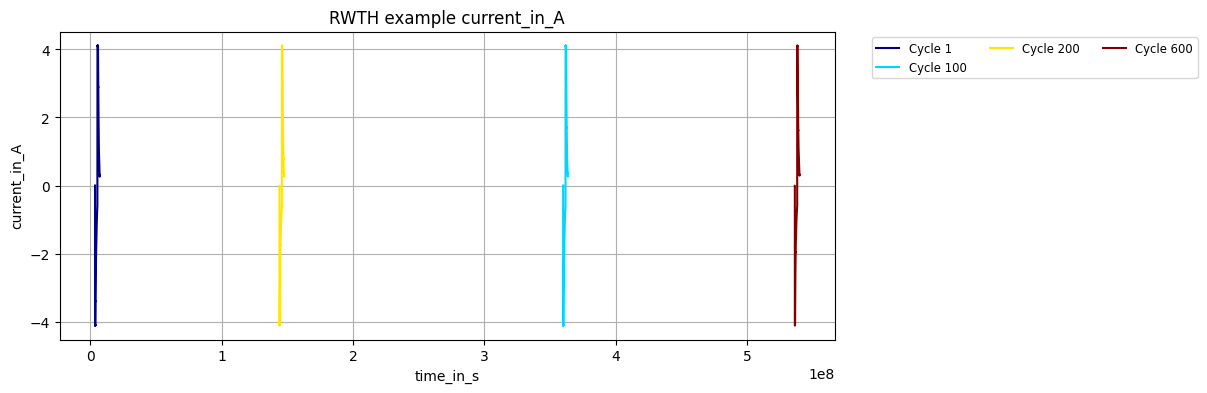

<Figure size 1000x400 with 0 Axes>

In [5]:
def pick_indices_by_cycle_number(cell: BatteryData, cycle_numbers: list[int], max_gap: int = 2) -> list[int]:
    idxs: list[int] = []
    cycle_list = list(cell.cycle_data or [])
    if not cycle_list:
        return idxs
    nums = [int(c.cycle_number) for c in cycle_list]
    for t in cycle_numbers:
        if t in nums:
            idxs.append(nums.index(t))
            continue
        diffs = [abs(n - t) for n in nums]
        j = int(np.argmin(diffs))
        if diffs[j] <= max_gap:
            idxs.append(j)
    return sorted(set(idxs))

def plot_cell_examples(cell: BatteryData, title_prefix: str, cycle_numbers=(1, 100, 200, 600)):
    idxs = pick_indices_by_cycle_number(cell, list(cycle_numbers), max_gap=5)
    print(title_prefix, cell.cell_id, 'selected indices:', idxs, 'cycle_numbers:', [cell.cycle_data[i].cycle_number for i in idxs])
    plot_cycle_attribute(cell.cycle_data, 'voltage_in_V', cycle_indices=idxs, figsize=(10, 4), title=f'{title_prefix} voltage_in_V')
    plot_cycle_attribute(cell.cycle_data, 'current_in_A', cycle_indices=idxs, figsize=(10, 4), title=f'{title_prefix} current_in_A')
    plot_cycle_attribute(cell.cycle_data, 'temperature_in_C', cycle_indices=idxs, figsize=(10, 4), title=f'{title_prefix} temperature_in_C')
    plot_cycle_attribute(
        cell.cycle_data,
        'coulombic_efficiency',
        cycle_indices=None,
        figsize=(10, 3),
        title=f'{title_prefix} coulombic_efficiency',
        cycle_start=0,
        cycle_end=min(500, len(cell.cycle_data)),
    )

if rwth_cells:
    plot_cell_examples(rwth_cells[0], 'RWTH example')
if calce_cells:
    plot_cell_examples(calce_cells[0], 'CALCE example')


## Distribution: SOH_end per dataset

SOH_end is computed as Q(end)/Q0 for each cell.


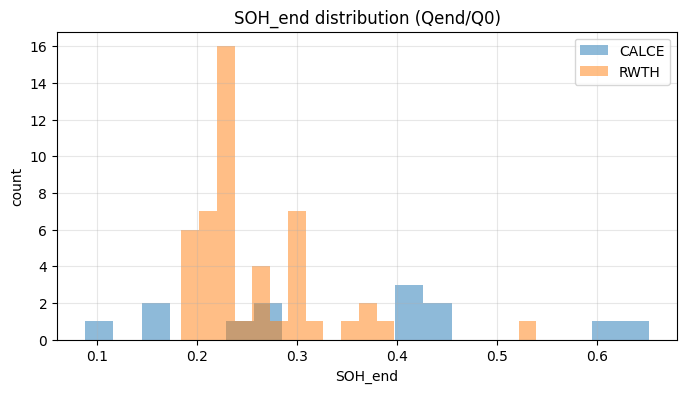

In [6]:
if not summary.empty:
    plt.figure(figsize=(8, 4))
    for tag, grp in summary.groupby('dataset'):
        vals = grp['soh_end'].dropna().to_numpy()
        plt.hist(vals, bins=20, alpha=0.5, label=tag)
    plt.title('SOH_end distribution (Qend/Q0)')
    plt.xlabel('SOH_end')
    plt.ylabel('count')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
